In [1]:
!pip uninstall tensorflow
!pip install tensorflow==2.1.0
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_gpu_available() == True)

Uninstalling tensorflow-1.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/freeze_graph
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-1.15.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-1.15.0
     |████████████████████████████████| 421.8MB 43kB/s 
     |████████████████████████████████| 3.8MB 40.0MB/s 
     |████████████████████████████████| 450kB 42.0MB/s 
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully un

# **03_05**

In [0]:
import numpy as np
import pickle 
from tensorflow.keras.callbacks import Callback,LearningRateScheduler,ModelCheckpoint
import os
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import pandas as pd
from loaders import load_model,ImageLabelLoader
from scipy.stats import norm

In [0]:
os.environ['KAGGLE_USERNAME'] = 'kimhaggie' # 독자의 캐글 ID
os.environ['KAGGLE_KEY'] = 'bf6a513484128eb597cf644e867f53d7' # 독자의 캐글 API Token

In [4]:
!kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.33G/1.33G [00:29<00:00, 60.6MB/s]
100% 1.33G/1.33G [00:29<00:00, 49.0MB/s]


In [5]:
!unzip celeba-dataset.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/197619.jpg  
  inflating: img_align_celeba/img_align_celeba/197620.jpg  
  in

In [0]:
# run params
section = 'vae'
run_id = '0001'
data_name = 'faces'
RUN_FOLDER = 'run/{}/'.format(section)
RUN_FOLDER += '_'.join([run_id, data_name])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #

In [60]:
from glob import glob
DATA_FOLDER = 'img_align_celeba'
INPUT_DIM = (218,178,3)
BATCH_SIZE = 32

filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.jpg')))

NUM_IMAGES = len(filenames)
NUM_IMAGES

202599

In [61]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(rescale=1./255)

data_flow = data_gen.flow_from_directory(DATA_FOLDER
                                         , target_size = INPUT_DIM[:2]
                                         , batch_size = BATCH_SIZE
                                         , shuffle = True
                                         , class_mode = 'input'
                                         , subset = "training"
                                            )

Found 202599 images belonging to 1 classes.


In [0]:
#### CALLBACKS
class CustomCallback(Callback):
    
    def __init__(self, run_folder, print_every_n_batches, initial_epoch, vae):
        self.epoch = initial_epoch
        self.run_folder = run_folder
        self.print_every_n_batches = print_every_n_batches
        self.vae = vae

    def on_batch_end(self, batch, logs={}):  
        if batch % self.print_every_n_batches == 0:
            z_new = np.random.normal(size = (1,self.vae.z_dim))
            reconst = self.vae.decoder.predict(np.array(z_new))[0].squeeze()

            filepath = os.path.join(self.run_folder, 'images', 'img_' + str(self.epoch).zfill(3) + '_' + str(batch) + '.jpg')
            if len(reconst.shape) == 2:
                plt.imsave(filepath, reconst, cmap='gray_r')
            else:
                plt.imsave(filepath, reconst)

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch += 1



def step_decay_schedule(initial_lr, decay_factor=0.5, step_size=1):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        new_lr = initial_lr * (decay_factor ** np.floor(epoch/step_size))
        
        return new_lr

    return LearningRateScheduler(schedule)

In [0]:
class VariationalAutoencoder():
    def __init__(self
        , input_dim
        , encoder_conv_filters
        , encoder_conv_kernel_size
        , encoder_conv_strides
        , decoder_conv_t_filters
        , decoder_conv_t_kernel_size
        , decoder_conv_t_strides
        , z_dim
        , use_batch_norm = False
        , use_dropout= False
        ):

        self.name = 'variational_autoencoder'

        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.z_dim = z_dim

        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        self.n_layers_encoder = len(encoder_conv_filters)
        self.n_layers_decoder = len(decoder_conv_t_filters)

        self._build()

    def _build(self):
        
        ### THE ENCODER
        encoder_input = tf.keras.layers.Input(shape=self.input_dim, name='encoder_input')

        x = encoder_input

        for i in range(self.n_layers_encoder):
            conv_layer = tf.keras.layers.Conv2D(
                filters = self.encoder_conv_filters[i]
                , kernel_size = self.encoder_conv_kernel_size[i]
                , strides = self.encoder_conv_strides[i]
                , padding = 'same'
                , name = 'encoder_conv_' + str(i)
                )

            x = conv_layer(x)

            if self.use_batch_norm:
                x = tf.keras.layers.BatchNormalization()(x)

            x = tf.keras.layers.LeakyReLU()(x)
  
            if self.use_dropout:
                x = tf.keras.layers.Dropout(rate = 0.25)(x)

        shape_before_flattening = tf.keras.backend.int_shape(x)[1:]

        x = tf.keras.layers.Flatten()(x)
        self.mu = tf.keras.layers.Dense(self.z_dim, name='mu')(x)
        self.log_var = tf.keras.layers.Dense(self.z_dim, name='log_var')(x)

        self.encoder_mu_log_var = tf.keras.Model(encoder_input, (self.mu, self.log_var))

        def sampling(args):
            mu, log_var = args
            epsilon = tf.keras.backend.random_normal(shape=tf.keras.backend.shape(mu), mean=0., stddev=1.)
            return mu + tf.keras.backend.exp(log_var / 2) * epsilon

        encoder_output = tf.keras.layers.Lambda(sampling, name='encoder_output')([self.mu, self.log_var])

        self.encoder = tf.keras.Model(encoder_input, encoder_output)
        
        

        ### THE DECODER

        decoder_input = tf.keras.layers.Input(shape=(self.z_dim,), name='decoder_input')

        x = tf.keras.layers.Dense(np.prod(shape_before_flattening))(decoder_input)
        x = tf.keras.layers.Reshape(shape_before_flattening)(x)

        for i in range(self.n_layers_decoder):
            conv_t_layer = tf.keras.layers.Conv2DTranspose(
                filters = self.decoder_conv_t_filters[i]
                , kernel_size = self.decoder_conv_t_kernel_size[i]
                , strides = self.decoder_conv_t_strides[i]
                , padding = 'same'
                , name = 'decoder_conv_t_' + str(i)
                )

            x = conv_t_layer(x)

            if i < self.n_layers_decoder - 1:
                if self.use_batch_norm:
                    x = tf.keras.layers.BatchNormalization()(x)
                x = tf.keras.layers.LeakyReLU()(x)
                if self.use_dropout:
                    x = tf.keras.layers.Dropout(rate = 0.25)(x)
            else:
                x = tf.keras.layers.Activation('sigmoid')(x)

            

        decoder_output = x

        self.decoder = tf.keras.Model(decoder_input, decoder_output)

        ### THE FULL VAE
        model_input = encoder_input
        model_output = self.decoder(encoder_output)

        self.model = tf.keras.Model(model_input, model_output)

    def compile(self, learning_rate, r_loss_factor):
        self.learning_rate = learning_rate

        ### COMPILATION
        def vae_r_loss(y_true, y_pred):
            r_loss = tf.keras.backend.mean(tf.keras.backend.square(y_true - y_pred), axis = [1,2,3])
            return r_loss_factor * r_loss

        def vae_kl_loss(y_true, y_pred):
            kl_loss =  -0.5 * tf.keras.backend.sum(1 + self.log_var - tf.keras.backend.square(self.mu) - tf.keras.backend.exp(self.log_var), axis = 1)
            return kl_loss

        def vae_loss(y_true, y_pred):
            r_loss = vae_r_loss(y_true, y_pred)
            kl_loss = vae_kl_loss(y_true, y_pred)
            return  r_loss + kl_loss

        optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
        self.model.compile(optimizer=optimizer, loss = vae_loss,  metrics = [vae_r_loss, vae_kl_loss], experimental_run_tf_function=False)


    def save(self, folder):

        if not os.path.exists(folder):
            os.makedirs(folder)
            os.makedirs(os.path.join(folder, 'viz'))
            os.makedirs(os.path.join(folder, 'weights'))
            os.makedirs(os.path.join(folder, 'images'))

        with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
            pickle.dump([
                self.input_dim
                , self.encoder_conv_filters
                , self.encoder_conv_kernel_size
                , self.encoder_conv_strides
                , self.decoder_conv_t_filters
                , self.decoder_conv_t_kernel_size
                , self.decoder_conv_t_strides
                , self.z_dim
                , self.use_batch_norm
                , self.use_dropout
                ], f)

        self.plot_model(folder)


    def load_weights(self, filepath):
        self.model.load_weights(filepath)

    def train(self, x_train, batch_size, epochs, run_folder, print_every_n_batches = 100, initial_epoch = 0, lr_decay = 1):

        custom_callback = CustomCallback(run_folder, print_every_n_batches, initial_epoch, self)
        lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=1)
        
        checkpoint_filepath=os.path.join(run_folder, "weights/weights-{epoch:03d}-{loss:.2f}.h5")
        checkpoint1 = ModelCheckpoint(checkpoint_filepath, save_weights_only = True, verbose=1)
        checkpoint2 = ModelCheckpoint(os.path.join(run_folder, 'weights/weights.h5'), save_weights_only = True, verbose=0)

        callbacks_list = [checkpoint1, checkpoint2, custom_callback, lr_sched]

        self.model.fit(     
            x_train
            , x_train
            , batch_size = batch_size
            , shuffle = True
            , epochs = epochs
            , initial_epoch = initial_epoch
            , callbacks = callbacks_list
            ,verbose=1
        )



    def train_with_generator(self, data_flow, epochs, steps_per_epoch, run_folder, print_every_n_batches = 100, initial_epoch = 0, lr_decay = 1, ):

        custom_callback = CustomCallback(run_folder, print_every_n_batches, initial_epoch, self)
        lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=1)

        checkpoint_filepath=os.path.join(run_folder, "weights/weights-{epoch:03d}-{loss:.2f}.h5")
        checkpoint1 = ModelCheckpoint(checkpoint_filepath, save_weights_only = True, verbose=1)
        checkpoint2 = ModelCheckpoint(os.path.join(run_folder, 'weights/weights.h5'), save_weights_only = True, verbose=1)

        callbacks_list = [checkpoint1, checkpoint2, custom_callback, lr_sched]

        self.model.save_weights(os.path.join(run_folder, 'weights/weights.h5'))
                
        self.model.fit_generator(
            data_flow
            , shuffle = True
            , epochs = epochs
            , initial_epoch = initial_epoch
            , callbacks = callbacks_list
            , steps_per_epoch=steps_per_epoch 
            ,verbose=1
            )


    
    def plot_model(self, run_folder):
        plot_model(self.model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.encoder, to_file=os.path.join(run_folder ,'viz/encoder.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.decoder, to_file=os.path.join(run_folder ,'viz/decoder.png'), show_shapes = True, show_layer_names = True)


In [0]:
vae = VariationalAutoencoder(
                input_dim = INPUT_DIM
                , encoder_conv_filters=[32,64,64, 64]
                , encoder_conv_kernel_size=[3,3,3,3]
                , encoder_conv_strides=[2,2,2,2]
                , decoder_conv_t_filters=[64,64,32,3]
                , decoder_conv_t_kernel_size=[3,3,3,3]
                , decoder_conv_t_strides=[2,2,2,2]
                , z_dim=200
                , use_batch_norm=True
                , use_dropout=True)

if mode == 'build':
    vae.save(RUN_FOLDER)
else:
    vae.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

In [65]:
vae.encoder.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 64, 64, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 64, 64, 32)   128         encoder_conv_0[0][0]             
__________________________________________________________________________________________________
leaky_re_lu_7 (LeakyReLU)       (None, 64, 64, 32)   0           batch_normalization_7[0][0]      
____________________________________________________________________________________________

In [66]:
vae.decoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 200)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              823296    
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 64)          0         
_________________________________________________________________
decoder_conv_t_0 (Conv2DTran (None, 16, 16, 64)        36928     
_________________________________________________________________
batch_normalization_11 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 16, 16, 64)        0   

In [0]:
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 10000
EPOCHS = 200
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

In [0]:
vae.compile(LEARNING_RATE, R_LOSS_FACTOR)

In [0]:
vae.train_with_generator(     
    data_flow
    , epochs = EPOCHS
    , steps_per_epoch = NUM_IMAGES / BATCH_SIZE
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , initial_epoch = INITIAL_EPOCH
)

학습 생략

# **03_06**

In [0]:
mode = 'load'

In [0]:
vae = VariationalAutoencoder(
                input_dim = INPUT_DIM
                , encoder_conv_filters=[32,64,64, 64]
                , encoder_conv_kernel_size=[3,3,3,3]
                , encoder_conv_strides=[2,2,2,2]
                , decoder_conv_t_filters=[64,64,32,3]
                , decoder_conv_t_kernel_size=[3,3,3,3]
                , decoder_conv_t_strides=[2,2,2,2]
                , z_dim=200
                , use_batch_norm=True
                , use_dropout=True)

if mode == 'build':
    vae.save(RUN_FOLDER)
else:
    vae.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

In [0]:
INPUT_DIM = (128,128,3)

att = pd.read_csv('list_attr_celeba.csv')

imageLoader = ImageLabelLoader('img_align_celeba/img_align_celeba', INPUT_DIM[:2])

Found 202599 validated image filenames.


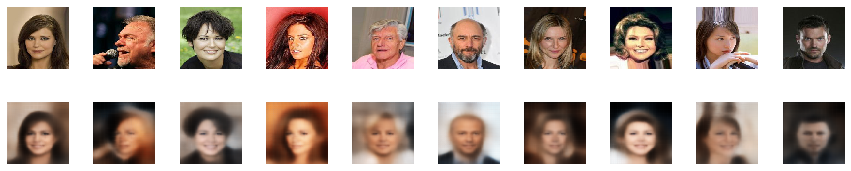

In [115]:
n_to_show = 10

data_flow_generic = imageLoader.build(att, n_to_show)

example_batch = next(data_flow_generic)
example_images = example_batch[0]
z_points = vae.encoder.predict(example_images)

reconst_images = vae.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')        
    sub.imshow(img)

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img)

20/20 [==============================] - 0s 14ms/step
(200, 200)


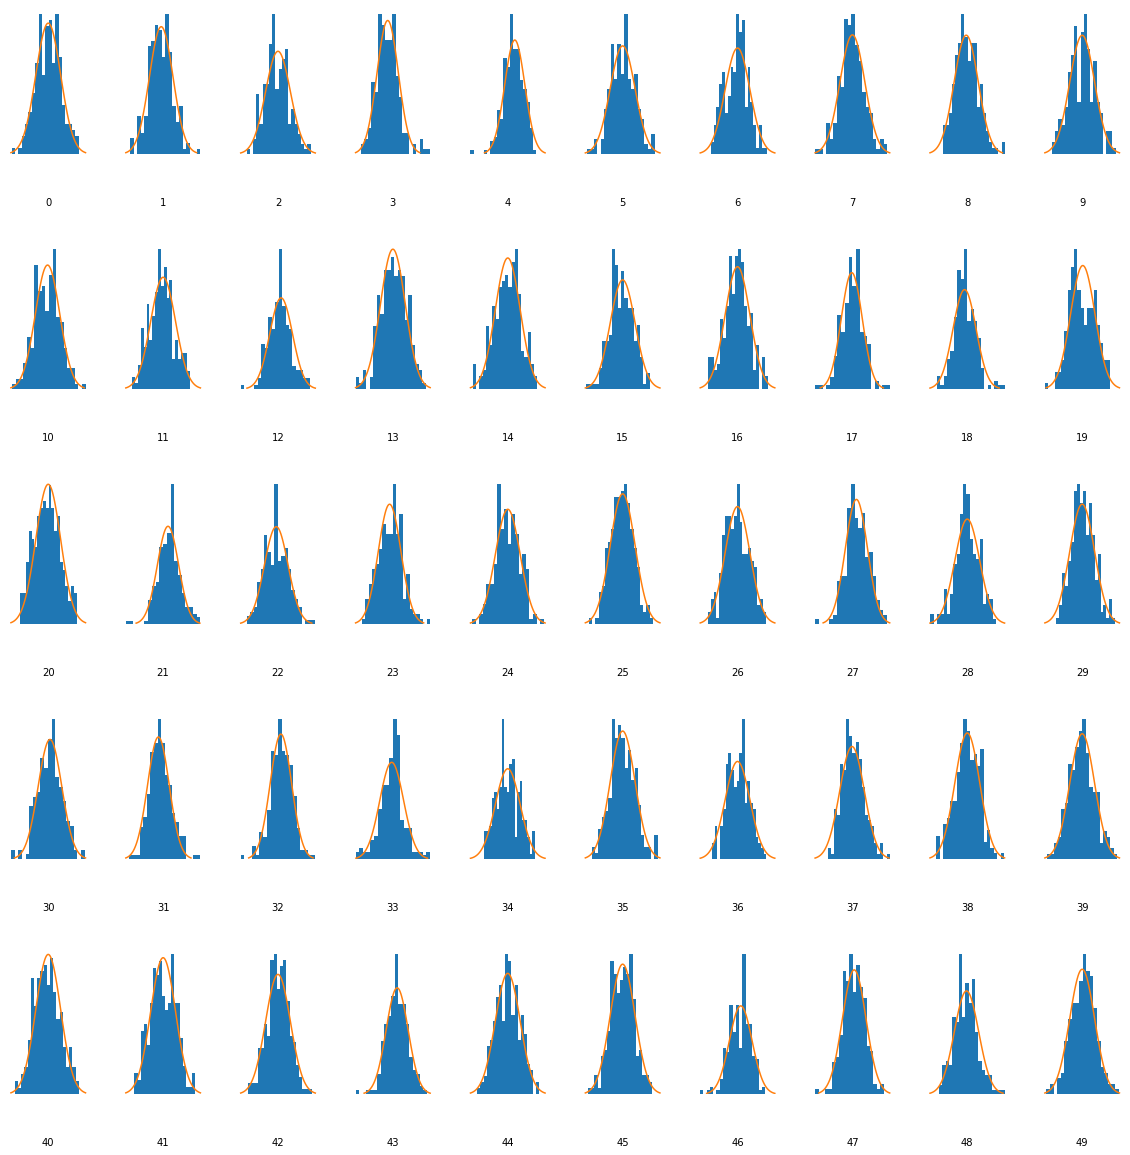

In [123]:
z_test = vae.encoder.predict_generator(data_flow_generic, steps = 20, verbose = 1)
print(z_test.shape)
x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(z_test[:,i], density=True, bins = 20)
    ax.axis('off')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()

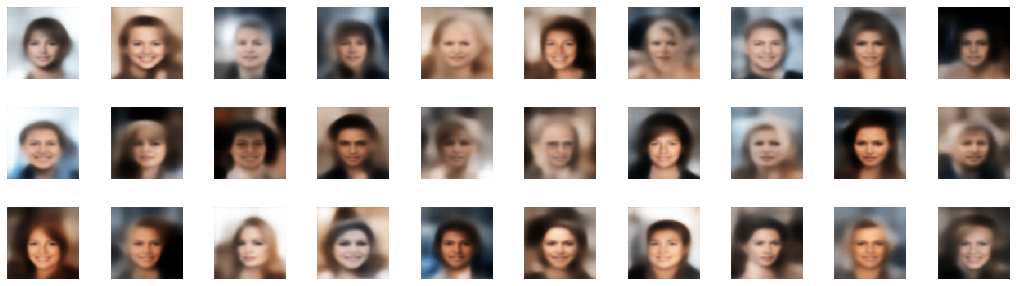

In [124]:
n_to_show = 30

znew = np.random.normal(size = (n_to_show,vae.z_dim))

reconst = vae.decoder.predict(np.array(znew))

fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n_to_show):
    ax = fig.add_subplot(3, 10, i+1)
    ax.imshow(reconst[i, :,:,:])
    ax.axis('off')

plt.show()

In [0]:
def get_vector_from_label(label, batch_size):

    data_flow_label = imageLoader.build(att, batch_size, label = label)

    origin = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_sum_POS = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_n_POS = 0
    current_mean_POS = np.zeros(shape = vae.z_dim, dtype = 'float32')

    current_sum_NEG = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape = vae.z_dim, dtype = 'float32')

    current_vector = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_dist = 0

    print('label: ' + label)
    print('images : POS move : NEG move :distance : 𝛥 distance')
    while(current_n_POS < 10000):

        batch = next(data_flow_label)
        im = batch[0]
        attribute = batch[1]

        z = vae.encoder.predict(np.array(im))

        z_POS = z[attribute==1]
        z_NEG = z[attribute==-1]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis = 0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS-current_mean_POS)

        if len(z_NEG) > 0: 
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis = 0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG-current_mean_NEG)

        current_vector = new_mean_POS-new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist


        print(str(current_n_POS)
              + '    : ' + str(np.round(movement_POS,3))
              + '    : ' + str(np.round(movement_NEG,3))
              + '    : ' + str(np.round(new_dist,3))
              + '    : ' + str(np.round(dist_change,3))
             )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print('Found the ' + label + ' vector')
            break

    return current_vector   

In [0]:
def add_vector_to_images(feature_vec):

    n_to_show = 5
    factors = [-4,-3,-2,-1,0,1,2,3,4]

    example_batch = next(data_flow_generic)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    z_points = vae.encoder.predict(example_images)

    fig = plt.figure(figsize=(18, 10))

    counter = 1

    for i in range(n_to_show):

        img = example_images[i].squeeze()
        sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis('off')        
        sub.imshow(img)

        counter += 1

        for factor in factors:

            changed_z_point = z_points[i] + feature_vec * factor
            changed_image = vae.decoder.predict(np.array([changed_z_point]))[0]

            img = changed_image.squeeze()
            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis('off')
            sub.imshow(img)

            counter += 1
    
    plt.show()

In [127]:
BATCH_SIZE = 500
attractive_vec = get_vector_from_label('Attractive', BATCH_SIZE)
mouth_open_vec = get_vector_from_label('Mouth_Slightly_Open', BATCH_SIZE)
smiling_vec = get_vector_from_label('Smiling', BATCH_SIZE)
lipstick_vec = get_vector_from_label('Wearing_Lipstick', BATCH_SIZE)
young_vec = get_vector_from_label('High_Cheekbones', BATCH_SIZE)
male_vec = get_vector_from_label('Male', BATCH_SIZE)

Found 202599 validated image filenames.
label: Attractive
images : POS move : NEG move :distance : 𝛥 distance
247    : 1.099    : 0.973    : 1.522    : 1.522
497    : 0.63    : 0.596    : 1.358    : -0.164
767    : 0.375    : 0.359    : 1.233    : -0.125
1028    : 0.253    : 0.259    : 1.161    : -0.072
1280    : 0.196    : 0.203    : 1.138    : -0.023
1537    : 0.17    : 0.17    : 1.082    : -0.056
1808    : 0.128    : 0.15    : 1.078    : -0.004
2068    : 0.113    : 0.114    : 1.061    : -0.017
2323    : 0.106    : 0.106    : 1.043    : -0.018
2592    : 0.091    : 0.101    : 1.03    : -0.013
2833    : 0.081    : 0.097    : 1.015    : -0.015
3075    : 0.074    : 0.082    : 1.001    : -0.014
3316    : 0.06    : 0.075    : 0.994    : -0.007
3582    : 0.066    : 0.062    : 0.994    : -0.0
3821    : 0.059    : 0.063    : 0.997    : 0.004
4075    : 0.06    : 0.059    : 0.995    : -0.003
4314    : 0.053    : 0.057    : 0.991    : -0.003
4580    : 0.052    : 0.05    : 0.992    : 0.001
4833  

In [128]:
eyeglasses_vec = get_vector_from_label('Eyeglasses', BATCH_SIZE)

Found 202599 validated image filenames.
label: Eyeglasses
images : POS move : NEG move :distance : 𝛥 distance
23    : 3.221    : 0.625    : 3.295    : 3.295
49    : 1.975    : 0.441    : 2.957    : -0.338
81    : 1.354    : 0.254    : 2.6    : -0.357
121    : 0.923    : 0.177    : 2.3    : -0.3
159    : 0.655    : 0.15    : 2.09    : -0.209
192    : 0.507    : 0.121    : 1.892    : -0.199
214    : 0.31    : 0.093    : 1.879    : -0.012
238    : 0.3    : 0.093    : 1.843    : -0.036
285    : 0.392    : 0.07    : 1.755    : -0.088
320    : 0.275    : 0.071    : 1.763    : 0.008
346    : 0.215    : 0.065    : 1.758    : -0.005
385    : 0.264    : 0.055    : 1.771    : 0.013
419    : 0.202    : 0.051    : 1.766    : -0.005
456    : 0.196    : 0.042    : 1.723    : -0.044
491    : 0.18    : 0.043    : 1.699    : -0.024
513    : 0.127    : 0.043    : 1.7    : 0.001
548    : 0.157    : 0.041    : 1.691    : -0.009
586    : 0.145    : 0.037    : 1.693    : 0.002
622    : 0.13    : 0.036    : 1

In [129]:
blonde_vec = get_vector_from_label('Blond_Hair', BATCH_SIZE)

Found 202599 validated image filenames.
label: Blond_Hair
images : POS move : NEG move :distance : 𝛥 distance
77    : 1.88    : 0.714    : 2.069    : 2.069
159    : 1.179    : 0.529    : 1.729    : -0.34
230    : 0.592    : 0.297    : 1.652    : -0.077
309    : 0.465    : 0.2    : 1.605    : -0.047
394    : 0.364    : 0.154    : 1.565    : -0.04
463    : 0.265    : 0.129    : 1.554    : -0.01
529    : 0.22    : 0.094    : 1.549    : -0.005
603    : 0.203    : 0.081    : 1.552    : 0.002
688    : 0.2    : 0.083    : 1.529    : -0.023
765    : 0.161    : 0.07    : 1.516    : -0.012
832    : 0.13    : 0.066    : 1.516    : -0.0
913    : 0.14    : 0.06    : 1.507    : -0.009
980    : 0.124    : 0.057    : 1.497    : -0.01
1056    : 0.108    : 0.053    : 1.495    : -0.002
1127    : 0.103    : 0.048    : 1.495    : -0.001
1200    : 0.101    : 0.043    : 1.491    : -0.004
1286    : 0.106    : 0.041    : 1.483    : -0.007
1369    : 0.096    : 0.04    : 1.478    : -0.005
1454    : 0.092    : 0.

In [130]:
print('Attractive Vector')
add_vector_to_images(attractive_vec)

print('Mouth Open Vector')
add_vector_to_images(mouth_open_vec)

print('Smiling Vector')
add_vector_to_images(smiling_vec)

print('Lipstick Vector')
add_vector_to_images(lipstick_vec)

print('Young Vector')
add_vector_to_images(young_vec)

print('Male Vector')
add_vector_to_images(male_vec)

print('Eyeglasses Vector')
add_vector_to_images(eyeglasses_vec)

print('Blond Vector')
add_vector_to_images(blonde_vec)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
def morph_faces(start_image_file, end_image_file):

    factors = np.arange(0,1,0.1)

    att_specific = att[att['image_id'].isin([start_image_file, end_image_file])]
    att_specific = att_specific.reset_index()
    data_flow_label = imageLoader.build(att_specific, 2)

    example_batch = next(data_flow_label)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    z_points = vae.encoder.predict(example_images)


    fig = plt.figure(figsize=(18, 8))

    counter = 1

    img = example_images[0].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)

    counter+=1


    for factor in factors:

        changed_z_point = z_points[0] * (1-factor) + z_points[1]  * factor
        changed_image = vae.decoder.predict(np.array([changed_z_point]))[0]

        img = changed_image.squeeze()
        sub = fig.add_subplot(1, len(factors)+2, counter)
        sub.axis('off')
        sub.imshow(img)

        counter += 1

    img = example_images[1].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)

    plt.show()

Found 2 validated image filenames.


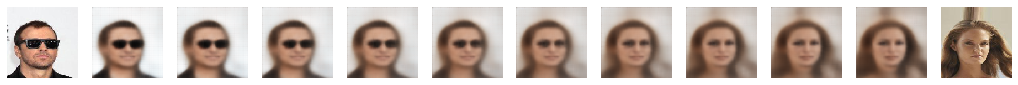

In [132]:
start_image_file = '000238.jpg' 
end_image_file = '000193.jpg' #glasses

morph_faces(start_image_file, end_image_file)

Found 2 validated image filenames.


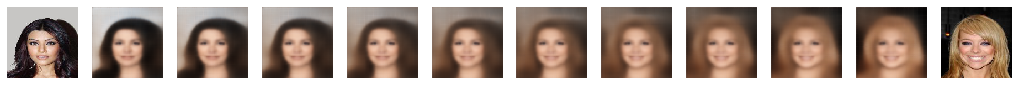

In [133]:
start_image_file = '000112.jpg'
end_image_file = '000258.jpg'

morph_faces(start_image_file, end_image_file)

Found 2 validated image filenames.


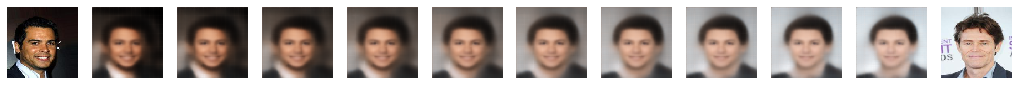

In [134]:
start_image_file = '000230.jpg'
end_image_file = '000712.jpg'

morph_faces(start_image_file, end_image_file)